In [1]:
import os
import errno
import argparse

import numpy as np
import skimage.io
import skimage.external.tifffile as tiff
import skimage.morphology
from tensorflow.python.keras.optimizers import SGD
from tensorflow.python.keras import backend as K
from scipy import stats

from deepcell import get_image_sizes
from deepcell import make_training_data
from deepcell import bn_feature_net_31x31
from deepcell import dilated_bn_feature_net_31x31
from deepcell import train_model_watershed
from deepcell import train_model_watershed_sample
from deepcell import bn_dense_feature_net
from deepcell import rate_scheduler
from deepcell import train_model_disc, train_model_conv, train_model_sample
from deepcell import run_models_on_directory
from deepcell import export_model
from deepcell import get_data

# data options
DATA_OUTPUT_MODE = 'sample'
BORDER_MODE = 'valid' if DATA_OUTPUT_MODE == 'sample' else 'same'
RESIZE = True
RESHAPE_SIZE = 2048
N_EPOCHS = 40
WINDOW_SIZE = (15,15)
BATCH_SIZE = 64
MAX_TRAIN = 1e8
BINS = 4

INT_ONLY = True
REMAKE_CONV = False

# Check for channels_first or channels_last
IS_CHANNELS_FIRST = K.image_data_format() == 'channels_first'
ROW_AXIS = 2 if IS_CHANNELS_FIRST else 1
COL_AXIS = 3 if IS_CHANNELS_FIRST else 2
CHANNEL_AXIS = 1 if IS_CHANNELS_FIRST else -1



# filepath constants
DATA_DIR = '/data/data'
MODEL_DIR = '/data/models'
NPZ_DIR = '/data/npz_data'
RESULTS_DIR = '/data/results'
EXPORT_DIR = '/data/exports'

PREFIX_SEG = 'tissues/mibi/samir'
PREFIX_CLASS = 'tissues/mibi/mibi_full'
PREFIX_SAVE = 'tissues/mibi/pipeline'
RUN_DIR = 'set1'

TRAIN_DIR_SAMPLE = ['set1', 'set2']
TRAIN_DIR_CLASS_RANGE = range(1, 39+1)

NUM_FEATURES_IN_SEG = 2
NUM_FEATURES_OUT_SEG = 3
NUM_FEATURES_CLASS = 17



FG_BG_DATA_FILE = 'mibi_pipe_wshedFB_{}_{}'.format(K.image_data_format(), DATA_OUTPUT_MODE)
CONV_DATA_FILE = 'mibi_watershedconv_{}_{}'.format(K.image_data_format(), 'conv')
MODEL_FGBG = '2018-07-13_mibi_31x31_channels_last_sample__0.h5'
CHANNELS_SEG = ['dsDNA', 'Ca', 'H3K27me3', 'H3K9ac', 'Ta']  #Add P?

raw_dir = 'raw'
data_location = os.path.join(DATA_DIR, PREFIX_SEG, RUN_DIR, raw_dir)
output_location = os.path.join(RESULTS_DIR, PREFIX_SEG)
channel_names = CHANNELS_SEG
image_size_x, image_size_y = get_image_sizes(data_location, channel_names)

Using TensorFlow backend.


In [2]:
# define model type
model_fn = dilated_bn_feature_net_31x31
fgbg_weights_file = os.path.join(MODEL_DIR, PREFIX_SEG, MODEL_FGBG)


# Load the training data from NPZ into a numpy array
testing_data = np.load(os.path.join(NPZ_DIR, PREFIX_SEG, CONV_DATA_FILE + '.npz'))

X, y = testing_data['X'], testing_data['y']
print('X.shape: {}\ny.shape: {}'.format(X.shape, y.shape))

# save the size of the input data for input_shape model parameter
size = X.shape[ROW_AXIS:COL_AXIS + 1]
if IS_CHANNELS_FIRST:
    input_shape = (X.shape[CHANNEL_AXIS], size[0], size[1])
else:
#     input_shape = (size[0], size[1], X.shape[CHANNEL_AXIS])
    input_shape = (size[0], size[1], len(CHANNELS_SEG))

    
run_fgbg_model = model_fn(n_features=3, input_shape=input_shape)
run_fgbg_model.load_weights(fgbg_weights_file)

# get the data to run models on
training_data_file = os.path.join(NPZ_DIR, PREFIX_SEG, CONV_DATA_FILE + '.npz')
train_dict, (X_test, y_test) = get_data(training_data_file, mode='conv', seed=21)

# run model
test_images_fgbg = run_fgbg_model.predict(X_test)

X.shape: (1, 2048, 2048, 5)
y.shape: (1, 2018, 2018, 3)
Using dilated feature net 31x31 with batch normalization


In [3]:
# threshold the foreground/background
# and remove back ground from watershed transform

# threshold edge
edge = test_images_fgbg[:,:,:,0] 
edge[edge < 0.4] = 0
edge[edge > 0.4] = 1

# threshold interior
interior = test_images_fgbg[:, :, :, 1]
interior[interior > 0.2] = 1
interior[interior < 0.2] = 0

# instantiate the foreground threshold as interior, bounded by edge
fg_thresh = np.logical_and(interior==1, edge==0)


# # erode away small objects and weak connections
# fg_thresh = skimage.morphology.binary_erosion(fg_thresh)
fg_thresh = skimage.morphology.binary_erosion(fg_thresh)
# # either erode more or remove small objects

# # dilate to join objects
fg_thresh = skimage.morphology.binary_dilation(fg_thresh)
fg_thresh = skimage.morphology.binary_dilation(fg_thresh)
fg_thresh = skimage.morphology.binary_dilation(fg_thresh)
# fg_thresh = skimage.morphology.binary_dilation(fg_thresh)



#fg_thresh = np.expand_dims(fg_thresh, axis=CHANNEL_AXIS)

#argmax_images_post_fgbg = argmax_images * fg_thresh


In [4]:
from scipy import ndimage as ndi
from skimage.morphology import watershed
from skimage.feature import peak_local_max

distance = ndi.distance_transform_edt(fg_thresh)


print('shape of distance is:', distance.shape)
print('shape of fg_thresh is:', fg_thresh.shape)
print('shape of interior is:', interior.shape)

#watershed_images = []

local_maxi = peak_local_max(distance, min_distance=10, indices=False, labels=fg_thresh, exclude_border=False)
    
markers = ndi.label(local_maxi)[0]
segments = watershed(-distance, markers, mask=fg_thresh)
    
print(segments.shape)
    


shape of distance is: (1, 2018, 2018)
shape of fg_thresh is: (1, 2018, 2018)
shape of interior is: (1, 2018, 2018)
(1, 2018, 2018)


In [7]:
dsDNA = np.copy(X_test[0,:,:,0])
dsDNA = dsDNA[15:-15, 15:-15]




wshed_segmentation = segments

#print(wshed_segmentation.shape)

# use the labeled foreground threshold as the basis rather than the watershed output
#wshed_segmentation = skimage.measure.label(  np.squeeze(fg_thresh), connectivity=2)


#wshed_ero = skimage.morphology.erosion(np.copy(watershed_segmentation))
#watershed_segmentation[watershed_segmentation != wshed_ero] = 0

wshed_copy = np.copy(wshed_segmentation)



#wshed_ero = skimage.morphology.erosion(np.copy(wshed_copy))
#wshed_copy[wshed_copy != wshed_ero] = 0

#wshed_ero = skimage.morphology.erosion(np.copy(wshed_dil))
#wshed_dil[wshed_dil != wshed_ero] = 0

#wshed_dil = skimage.morphology.dilation(wshed_dil)
#wshed_dil2[((wshed_dil2 != 0) & (wshed_dil2 !=wshed_dil))] = wshed_dil








#wshed_ero = skimage.morphology.erosion(np.copy(wshed_copy))
#wshed_copy[wshed_copy != wshed_ero] = 0


#wshed_dil = skimage.morphology.dilation(wshed_copy)
#wshed_dil[((wshed_dil != wshed_copy) & (wshed_copy!= 0))] = 0
#wshed_copy = wshed_dil

#wshed_dil = skimage.morphology.dilation(wshed_copy)
#wshed_dil[((wshed_dil != wshed_copy) & (wshed_copy!= 0))] = 0
#wshed_copy = wshed_dil

#wshed_dil = skimage.morphology.dilation(wshed_copy)
#wshed_dil[((wshed_dil != wshed_copy) & (wshed_copy!= 0))] = 0
#wshed_copy = wshed_dil





#wshed_copy[((wshed_copy == 0) & (wshed_dil != 0))] = 0




#wshed_dil = skimage.morphology.dilation(wshed_dil)


#wshed_dil = skimage.morphology.dilation(wshed_dil)
#wshed_dil = skimage.morphology.dilation(wshed_dil)

#wshed_dil = skimage.morphology.dilation(wshed_dil)
#wshed_dil = skimage.morphology.dilation(wshed_dil)




# erode once at the end to delineate individual cells
#wshed_ero = skimage.morphology.erosion(np.copy(wshed_dil))
#wshed_dil[wshed_dil != wshed_ero] = 0

# trim the dilated watershed output to fit the segmentation mask
#wshed_dil[interior == 0] = 0



#watershed_segmentation = wshed_segmentation

wshed_ero = skimage.morphology.erosion(np.copy(wshed_copy))
wshed_copy[wshed_copy != wshed_ero] = 0


watershed_segmentation = wshed_copy


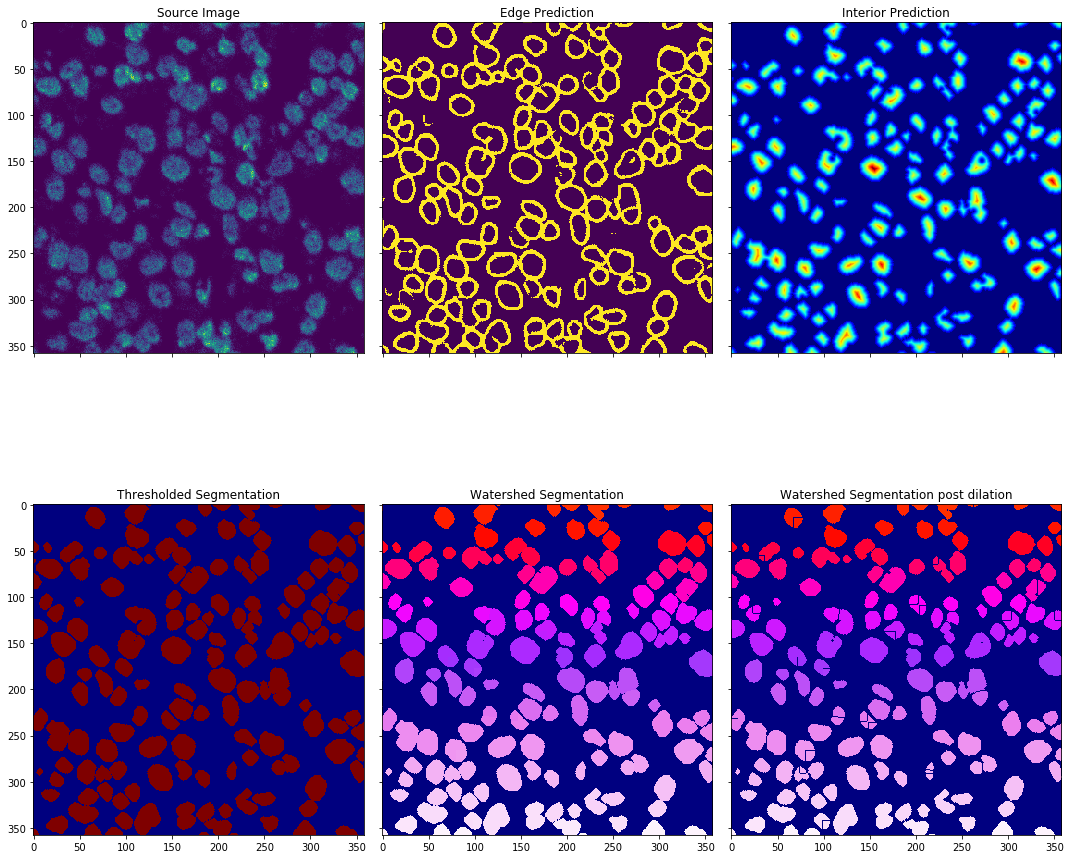

In [8]:
# Plot the results
import matplotlib.pyplot as plt

index = 0

fig, axes = plt.subplots(ncols=3, nrows=2, figsize=(15, 15), sharex=True, sharey=True)
ax = axes.ravel()

winx1 = 830
winx2 = -830

winy1 = 830
winy2 = -830

source = dsDNA
source = source[winy1:winy2, winx1:winx2]
ax[0].imshow(source)
ax[0].set_title('Source Image')


edge_pred = edge[0, winy1:winy2, winx1:winx2]
ax[1].imshow(edge_pred)
ax[1].set_title('Edge Prediction')


interior_pred = distance[0, winy1:winy2, winx1:winx2]
ax[2].imshow(interior_pred, cmap='jet')
ax[2].set_title('Interior Prediction')


interior_pred = fg_thresh[0, :, :]
seg_thresh = interior_pred[winy1:winy2, winx1:winx2]
ax[3].imshow(seg_thresh, cmap='jet')
ax[3].set_title('Thresholded Segmentation')



wshed_predil = segments[0, :, :]
wshed_predil = wshed_predil[winy1:winy2, winx1:winx2]
ax[4].imshow(wshed_predil, cmap='gist_ncar')
ax[4].set_title('Watershed Segmentation')



wshed_seg = watershed_segmentation[0, winy1:winy2, winx1:winx2]
ax[5].imshow(wshed_seg, cmap='gist_ncar')
ax[5].set_title('Watershed Segmentation post dilation')

fig.tight_layout()
plt.show()